In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
import time
from collections import Counter
from imblearn.over_sampling import RandomOverSampler


from sklearn.metrics import precision_recall_fscore_support 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_json('DiSmldata.json')

In [4]:
my_stop_words = ENGLISH_STOP_WORDS.union(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                                         'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                                         'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                                         'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                                         '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                                          "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                                          'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                                          'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                                          '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl'])

In [5]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(df[['hash_count', 'emoji_count','clean_text',
                                                        'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']], df['label'],test_size =0.20, random_state = 77)

In [6]:
#setting min_df and max_df with 1-3 ngrams

In [7]:
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.clean_text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.label
    return X, y
X, y = make_xy(df)

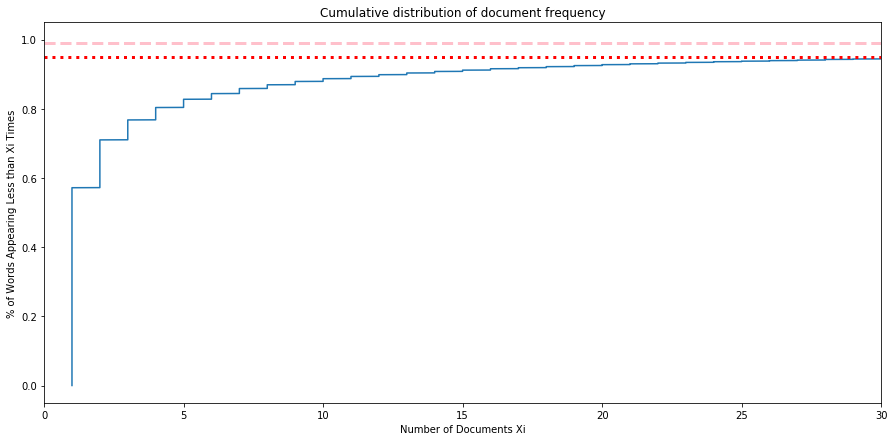

In [8]:
data = np.sum(X>0,axis=0)
sorted_df = np.sort(data).reshape(-1,1)
yvals=np.arange(len(sorted_df))/float(len(sorted_df)-1)
plt.figure(figsize = (15,7))
plt.plot(sorted_df,yvals)
plt.xlim([0,30])
plt.axhline(0.95, c = 'red', linestyle = ':', linewidth = 3)
plt.axhline(0.99, c = 'pink', linestyle = '--', linewidth =3)
plt.xlabel('Number of Documents Xi')
plt.ylabel('% of Words Appearing Less than Xi Times')
plt.title('Cumulative distribution of document frequency')
plt.show()

In [ ]:
#Set to 25 max_df 3 min_df ngrams = (1,3)

In [22]:
#Count vectorizer Document term matrix

count_vecto = CountVectorizer(stop_words = my_stop_words, min_df = 3, max_df = 25, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [23]:
X_train_vect.shape

(70008, 37985)

In [24]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [25]:
#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 5901.172 / Predict time: 15.717 ---- Precision: 0.576 / Recall: 0.536 / Accuracy: 0.576


In [26]:
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect.columns), reverse=True))[0:20]

[(0.03463070306197562, 'hash_count'),
 (0.032715147770954904, 'sadness'),
 (0.03225378450001332, 'tweet_len'),
 (0.028802840174401604, 'joy'),
 (0.026558124245003867, 'fear'),
 (0.021662389523765882, 'cap_count'),
 (0.020722904050232412, 'anger'),
 (0.02021023891451193, 'disgust'),
 (0.019755019437540416, 'punc_count'),
 (0.018961727578031867, 'anticipation'),
 (0.016554586259360408, 'trust'),
 (0.010839112050473559, 'surprise'),
 (0.007916042370426285, 'emoji_count'),
 (0.0015180988656620287, 284),
 (0.0006805298567999763, 17186),
 (0.0006406729802447634, 13820),
 (0.0006224576303510194, 23212),
 (0.0005886525000925053, 33153),
 (0.0005873421602347881, 23071),
 (0.0005818470882766889, 26723)]

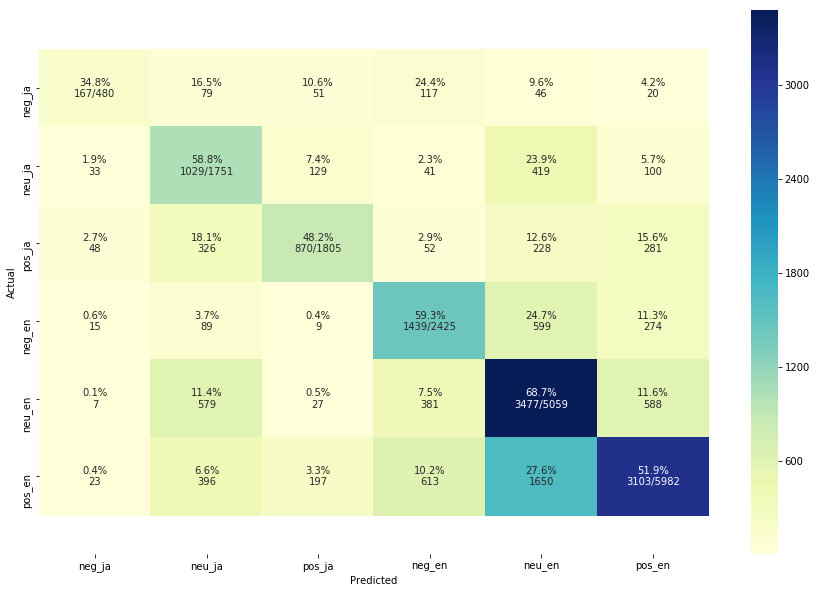

In [27]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

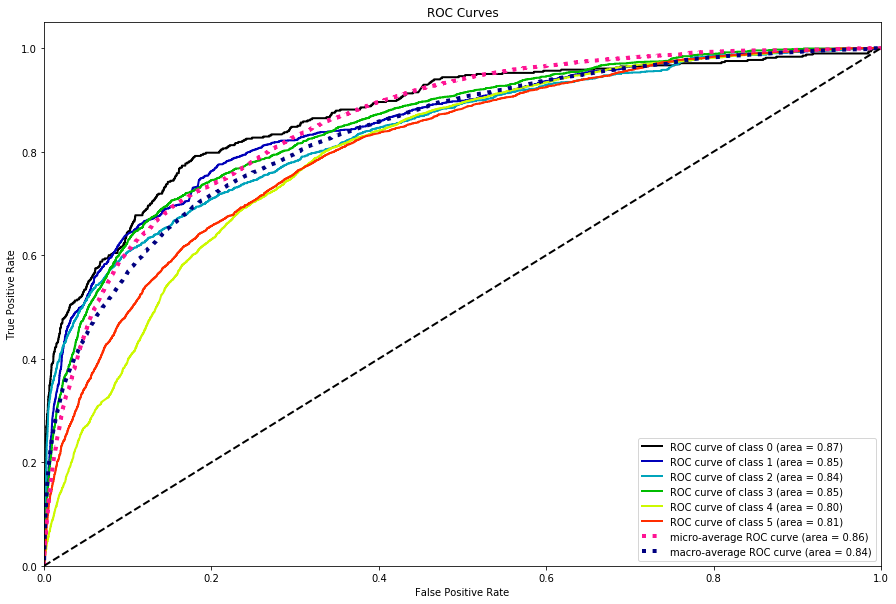

In [28]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = rf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

y_prob = rf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.842279 (macro),
0.837904 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.836744 (macro),
0.820504 (weighted by prevalence)


In [ ]:
#Max Features 

In [38]:
#Count vectorizer Document term matrix 37900

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 37900, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [39]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [40]:
#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 7931.878 / Predict time: 16.833 ---- Precision: 0.756 / Recall: 0.655 / Accuracy: 0.741


In [41]:
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect.columns), reverse=True))[0:20]

[(0.02329572063768534, 'tweet_len'),
 (0.017764418695587387, 'hash_count'),
 (0.017079559931789716, 'cap_count'),
 (0.016070471005746677, 'punc_count'),
 (0.01409241138241366, 'sadness'),
 (0.013154767333634262, 'joy'),
 (0.012714203756209273, 'fear'),
 (0.011395036750120742, 'anger'),
 (0.010491831113985925, 'anticipation'),
 (0.01003758386702932, 'disgust'),
 (0.00886596262701422, 'trust'),
 (0.007749798743556188, 'emoji_count'),
 (0.006401199816089388, 'surprise'),
 (0.004470377466766118, 6080),
 (0.004133091368966971, 18064),
 (0.0030123002535830104, 13423),
 (0.0028606804403675514, 18892),
 (0.0028377801112691803, 32022),
 (0.0025189633918018444, 12230),
 (0.0022097800963515944, 27241)]

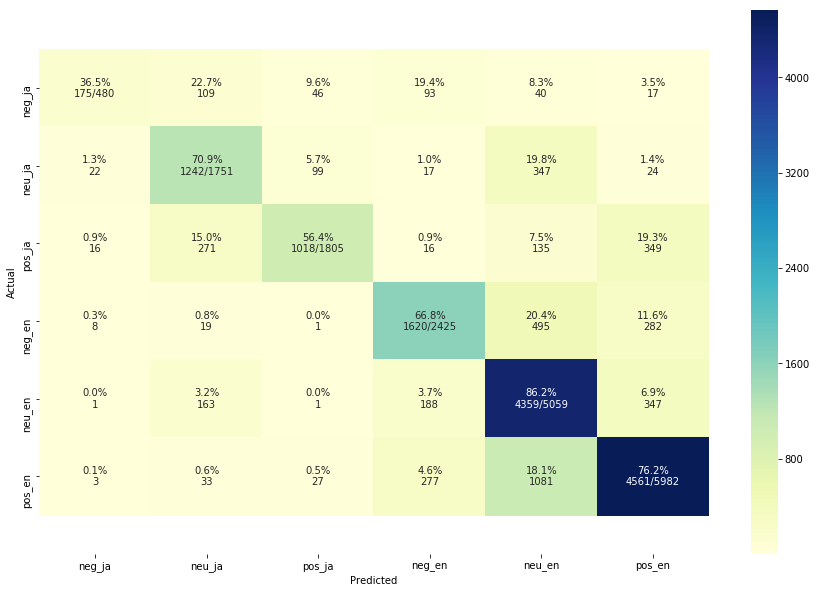

In [42]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

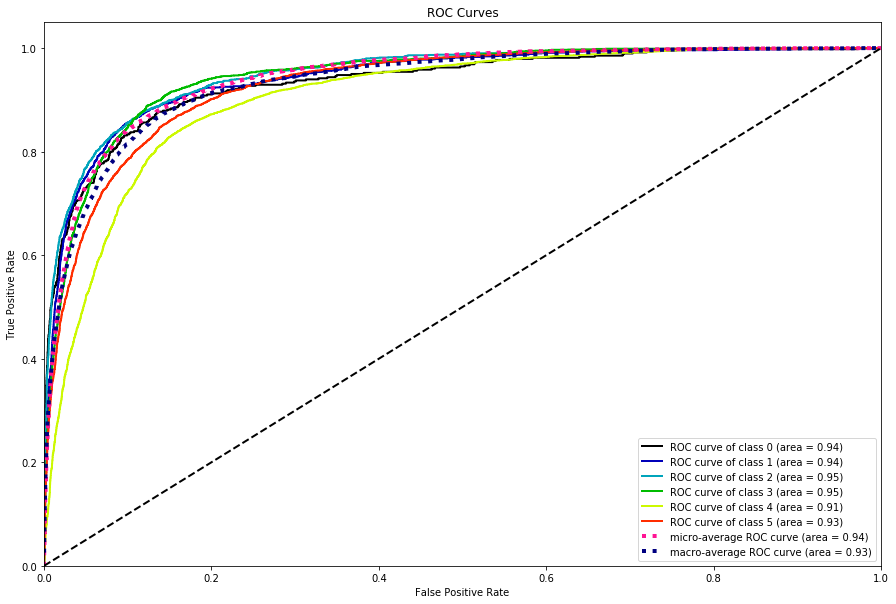

In [43]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = rf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score

y_prob = rf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.929873 (macro),
0.933799 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.934711 (macro),
0.928441 (weighted by prevalence)


In [45]:
#Testing various Max features

In [46]:
def rand_for_feat(features, ngram):
    cv = CountVectorizer(stop_words = my_stop_words, max_features = features, ngram_range = ngram )
    cv_fit = cv.fit(X_train['clean_text'])
    cv_train = cv_fit.transform(X_train['clean_text'])
    cv_test = cv_fit.transform(X_test['clean_text'])
    X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(cv_train.toarray())], axis=1)
    X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(cv_test.toarray())], axis=1)
   
    #Balance
    ros = ros = RandomOverSampler(random_state=77)
    X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
    
    #Instantiate our model 
    rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                                n_jobs=-1)

    #Model Fit 
    start = time.time()
    rf.fit(X_resampled_ros, y_resampled_ros)
    end = time.time()
    fit_time = (end - start)

    #Model Predict 
    start = time.time()
    y_pred = rf.predict(X_test_vect)
    end = time.time()
    pred_time = (end - start)

    #Model Scoring 
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))




In [47]:
#Count vectorizer Document term matrix 20000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 20000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [48]:
X_train_vect.shape

(70008, 20013)

In [49]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [50]:
#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 5398.932 / Predict time: 10.223 ---- Precision: 0.757 / Recall: 0.661 / Accuracy: 0.749


In [51]:
#Count vectorizer Document term matrix 15000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 15000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [52]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [53]:
#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 1409.765 / Predict time: 8.993 ---- Precision: 0.761 / Recall: 0.666 / Accuracy: 0.753


In [54]:
#Count vectorizer Document term matrix 10000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 10000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [55]:
#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 1946.004 / Predict time: 8.463 ---- Precision: 0.761 / Recall: 0.673 / Accuracy: 0.76


In [56]:
#Count vectorizer Document term matrix 5000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 5000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [57]:
#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 1118.093 / Predict time: 6.775 ---- Precision: 0.753 / Recall: 0.673 / Accuracy: 0.761


In [37]:
#Count vectorizer Document term matrix 3000
rand_for_feat(3000, (1,3))

Fit time: 1104.67 / Predict time: 6.92 ---- Precision: 0.748 / Recall: 0.671 / Accuracy: 0.756


In [58]:
#Count Vectorizer 5000
rand_for_feat(5000, (1,3))

Fit time: 1755.982 / Predict time: 6.859 ---- Precision: 0.756 / Recall: 0.671 / Accuracy: 0.761


In [ ]:
# Fit time: 1104.67 / Predict time: 6.92 ---- Precision: 0.748 / Recall: 0.671 / Accuracy: 0.756
# Fit time: 1755.982 / Predict time: 6.859 ---- Precision: 0.756 / Recall: 0.671 / Accuracy: 0.761
# Fit time: 1946.004 / Predict time: 8.463 ---- Precision: 0.761 / Recall: 0.673 / Accuracy: 0.76
# Fit time: 1409.765 / Predict time: 8.993 ---- Precision: 0.761 / Recall: 0.666 / Accuracy: 0.753
# Fit time: 5398.932 / Predict time: 10.223 ---- Precision: 0.757 / Recall: 0.661 / Accuracy: 0.749
# Fit time: 7931.878 / Predict time: 16.833 ---- Precision: 0.756 / Recall: 0.655 / Accuracy: 0.741

In [59]:
rf_table = pd.DataFrame()
rf_table['train_time'] = [1104.67, 1755.982, 1946.004, 1409.765, 5398.932, 7931.878]
rf_table['features'] = [3000, 5000, 10000, 15000, 20000, 37900]
rf_table['accuracy_score'] = [0.756, 0.761, 0.76, 0.753, 0.749, 0.741]
rf_table['precision'] = [0.748, 0.756, 0.761, 0.761, 0.757, 0.756]
rf_table['recall'] = [0.671, 0.671, 0.673, 0.666, 0.661, 0.655]

In [60]:
rf_table

,train_time,features,accuracy_score,precision,recall
0,1104.670,3000,0.756,0.748,0.671
1,1755.982,5000,0.761,0.756,0.671
2,1946.004,10000,0.760,0.761,0.673
3,1409.765,15000,0.753,0.761,0.666
4,5398.932,20000,0.749,0.757,0.661
5,7931.878,37900,0.741,0.756,0.655


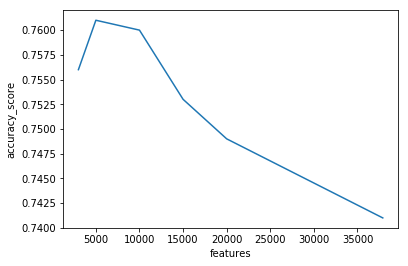

In [61]:
sns.lineplot(rf_table['features'], rf_table['accuracy_score'])
plt.show()

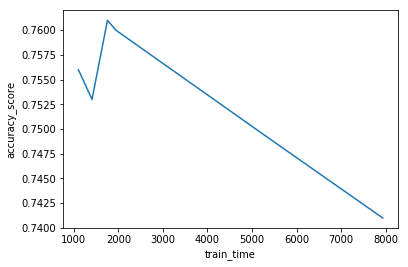

In [62]:
sns.lineplot(rf_table['train_time'], rf_table['accuracy_score'])
plt.show()

In [63]:
#Choosing the best model 

In [64]:
count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 5000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [65]:
#Random Forest Count vectorizer 


#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 2262.004 / Predict time: 6.735 ---- Precision: 0.758 / Recall: 0.673 / Accuracy: 0.761


In [66]:
from sklearn.metrics import classification_report
target_names = ['ja_neg', 'ja_neu', 'ja_pos', 'en_neg', 'en_neu', 'en_pos']
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

      ja_neg       0.76      0.36      0.49       480
      ja_neu       0.71      0.71      0.71      1751
      ja_pos       0.81      0.60      0.69      1805
      en_neg       0.72      0.71      0.72      2425
      en_neu       0.73      0.86      0.79      5059
      en_pos       0.82      0.80      0.81      5982

    accuracy                           0.76     17502
   macro avg       0.76      0.67      0.70     17502
weighted avg       0.76      0.76      0.76     17502



In [67]:
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect.columns), reverse=True))[0:20]

[(0.042742503132036126, 'tweet_len'),
 (0.02981511069363451, 'cap_count'),
 (0.028219897015989922, 'punc_count'),
 (0.02774240626763078, 'hash_count'),
 (0.018041647276357767, 'sadness'),
 (0.015524469886252596, 'joy'),
 (0.01452797834659272, 'fear'),
 (0.012361440393940016, 'emoji_count'),
 (0.011929729033797501, 'anticipation'),
 (0.011701611758526291, 'anger'),
 (0.010790189782835427, 'disgust'),
 (0.010236554330650604, 'trust'),
 (0.007519856112438645, 857),
 (0.007289517483873869, 'surprise'),
 (0.0065352265659783144, 2346),
 (0.004115159968867383, 2782),
 (0.004046098373274173, 2465),
 (0.0036526660231039863, 1592),
 (0.0034388077596611325, 4693),
 (0.0034195021837410394, 1704)]

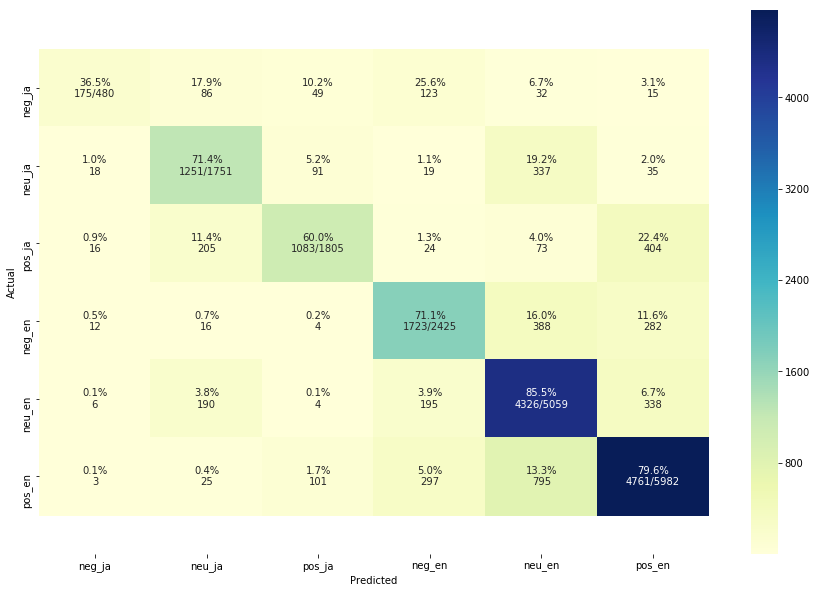

In [68]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

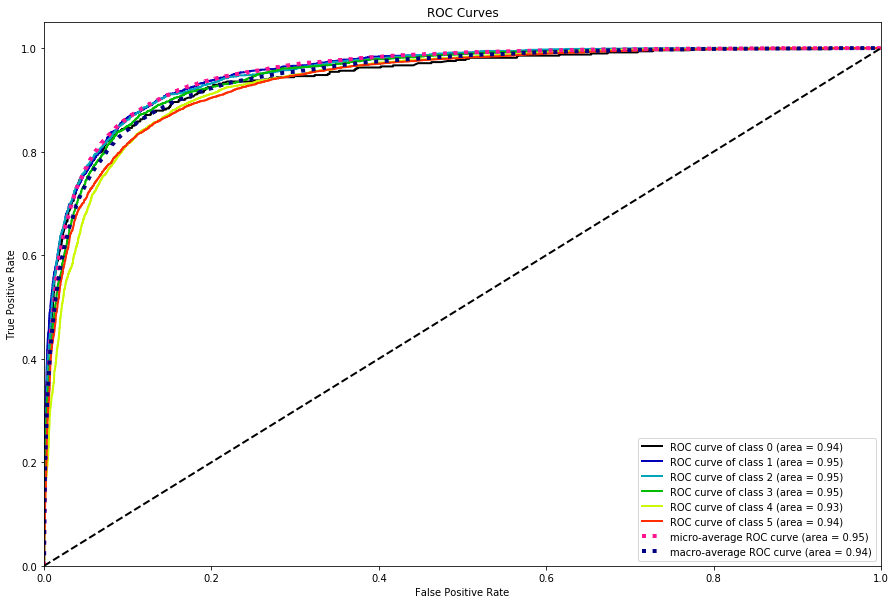

In [69]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = rf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [70]:
from sklearn.metrics import roc_auc_score

y_prob = rf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.937731 (macro),
0.942670 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.944040 (macro),
0.940475 (weighted by prevalence)
